In [15]:
# %matplotlib inline

import torch

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math

Let’s start with a straightforward example.
Next, we’ll create an input tensor full of evenly spaced values on the interval 
[0,2π], and specify requires_grad=True. (Like most functions that create tensors, torch.linspace() accepts an optional requires_grad option.) Setting this flag means that in every computation that follows, autograd will be accumulating the history of the computation in the output tensors of that computation.

In [16]:
a = torch.linspace(0., 2. * math.pi, steps=25, requires_grad=True)
print(a)

tensor([0.0000, 0.2618, 0.5236, 0.7854, 1.0472, 1.3090, 1.5708, 1.8326, 2.0944,
        2.3562, 2.6180, 2.8798, 3.1416, 3.4034, 3.6652, 3.9270, 4.1888, 4.4506,
        4.7124, 4.9742, 5.2360, 5.4978, 5.7596, 6.0214, 6.2832],
       requires_grad=True)


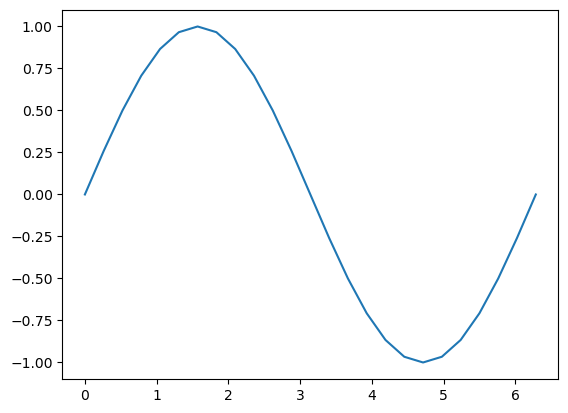

In [17]:
b = torch.sin(a)
plt.plot(a.detach(), b.detach())

Let’s have a closer look at the tensor b. When we print it, we see an indicator that it is tracking its computation history:

In [18]:
print(b)

tensor([ 0.0000e+00,  2.5882e-01,  5.0000e-01,  7.0711e-01,  8.6603e-01,
         9.6593e-01,  1.0000e+00,  9.6593e-01,  8.6603e-01,  7.0711e-01,
         5.0000e-01,  2.5882e-01, -8.7423e-08, -2.5882e-01, -5.0000e-01,
        -7.0711e-01, -8.6603e-01, -9.6593e-01, -1.0000e+00, -9.6593e-01,
        -8.6603e-01, -7.0711e-01, -5.0000e-01, -2.5882e-01,  1.7485e-07],
       grad_fn=<SinBackward0>)


This grad_fn gives us a hint that when we execute the backpropagation step and compute gradients, we’ll need to compute the derivative of 
sin(x) for all this tensor’s inputs.

Let’s perform some more computations:

In [19]:
c = 2 * b
print(c)

d = c + 1
print(d)

tensor([ 0.0000e+00,  5.1764e-01,  1.0000e+00,  1.4142e+00,  1.7321e+00,
         1.9319e+00,  2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,
         1.0000e+00,  5.1764e-01, -1.7485e-07, -5.1764e-01, -1.0000e+00,
        -1.4142e+00, -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00,
        -1.7321e+00, -1.4142e+00, -1.0000e+00, -5.1764e-01,  3.4969e-07],
       grad_fn=<MulBackward0>)
tensor([ 1.0000e+00,  1.5176e+00,  2.0000e+00,  2.4142e+00,  2.7321e+00,
         2.9319e+00,  3.0000e+00,  2.9319e+00,  2.7321e+00,  2.4142e+00,
         2.0000e+00,  1.5176e+00,  1.0000e+00,  4.8236e-01, -3.5763e-07,
        -4.1421e-01, -7.3205e-01, -9.3185e-01, -1.0000e+00, -9.3185e-01,
        -7.3205e-01, -4.1421e-01,  4.7684e-07,  4.8236e-01,  1.0000e+00],
       grad_fn=<AddBackward0>)


Finally, let’s compute a single-element output. When you call .backward() on a tensor with no arguments, it expects the calling tensor to contain only a single element, as is the case when computing a loss function.

In [20]:
out = d.sum()
print(out)

tensor(25., grad_fn=<SumBackward0>)


Each grad_fn stored with our tensors allows you to walk the computation all the way back to its inputs with its next_functions property. We can see below that drilling down on this property on d shows us the gradient functions for all the prior tensors. Note that a.grad_fn is reported as None, indicating that this was an input to the function with no history of its own.

In [21]:
print('d:')
print(d.grad_fn)
print(d.grad_fn.next_functions)
print(d.grad_fn.next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions)
print(d.grad_fn.next_functions[0][0].next_functions[0][0].next_functions[0][0].next_functions)
print('\nc:')
print(c.grad_fn)
print('\nb:')
print(b.grad_fn)
print('\na:')
print(a.grad_fn)

d:
((<MulBackward0 object at 0x7f3acaa71b70>, 0), (None, 0))
((<SinBackward0 object at 0x7f3acaa72aa0>, 0), (None, 0))
((<AccumulateGrad object at 0x7f3acaa71b70>, 0),)
()

c:

b:

a:
None


With all this machinery in place, how do we get derivatives out? You call the backward() method on the output, and check the input’s grad property to inspect the gradients:

tensor([ 2.0000e+00,  1.9319e+00,  1.7321e+00,  1.4142e+00,  1.0000e+00,
         5.1764e-01, -8.7423e-08, -5.1764e-01, -1.0000e+00, -1.4142e+00,
        -1.7321e+00, -1.9319e+00, -2.0000e+00, -1.9319e+00, -1.7321e+00,
        -1.4142e+00, -1.0000e+00, -5.1764e-01,  2.3850e-08,  5.1764e-01,
         1.0000e+00,  1.4142e+00,  1.7321e+00,  1.9319e+00,  2.0000e+00])


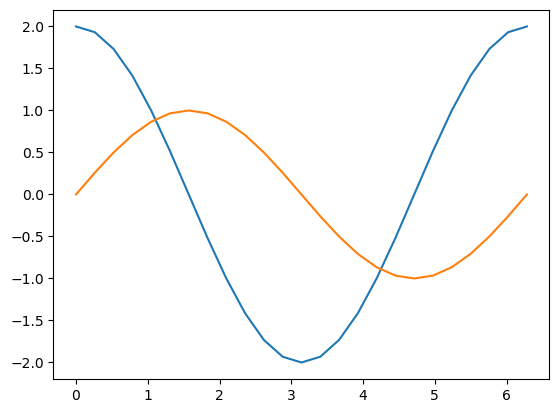

In [22]:
out.backward()
print(a.grad)
plt.plot(a.detach(), a.grad.detach())
plt.plot(a.detach(), b.detach())

Adding a constant, as we did to compute d, does not change the derivative. That leaves 
c=2∗b=2∗sin(a), the derivative of which should be 
2∗cos(a). Looking at the graph above, that’s just what we see.

Be aware that only leaf nodes of the computation have their gradients computed. If you tried, for example, print(c.grad) you’d get back None. In this simple example, only the input is a leaf node, so only it has gradients computed.